In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms.functional as F

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()
dummy_img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

# Pass the dummy image through Inception-v3 and find the layer where the output size has desired resolution

In [3]:
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT) 
list(model.named_modules())

[('',
  Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (c

In [4]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            # model.Mixed_6a,
            # model.Mixed_6b,
            # model.Mixed_6c,
            # model.Mixed_6d,
            # model.Mixed_6e,
            # model.Mixed_7a, 
            # model.Mixed_7b, 
            # model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)

feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 288, 132, 237])
Number of channels: 288
Spatial dimensions: 132x237


# Test Feature Extractor up to layer 5d

In [5]:
def visualize_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1'):
    
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]

    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std=[0.229, 0.224, 0.225]
    sample_images = image_files[:3]  
        
    transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=image_net_mean, std=image_net_std)
    ])

    for img_path in sample_images:

        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)  

        with torch.no_grad():
            features = feature_extractor(img_tensor)

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Original image dimensions: {img_w}x{img_h}")
        print(f"Feature map shape: {features.shape}")

        plt.figure(figsize=(10, 5.625))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        feature_map = features[0].sum(dim=0).cpu().numpy()
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f"Feature Map (Sum of {features.shape[1]} channels)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Image: 000001.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 288, 132, 237])


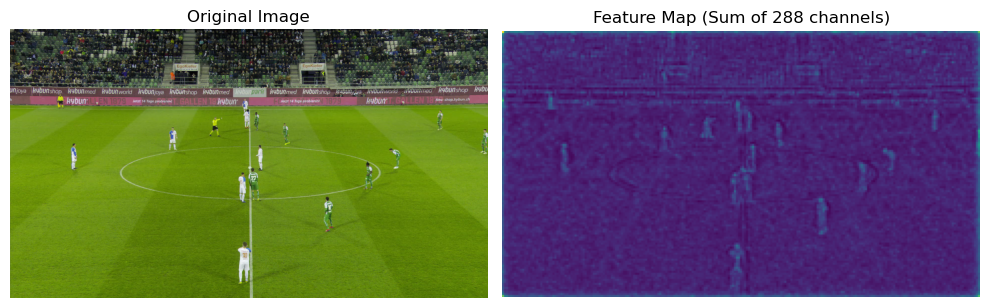

Image: 000002.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 288, 132, 237])


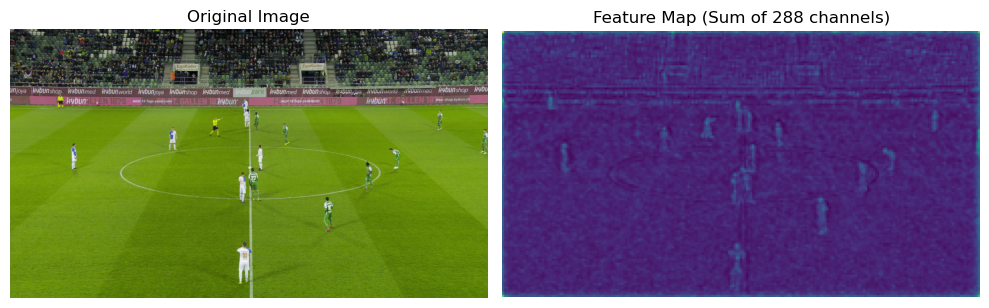

Image: 000003.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 288, 132, 237])


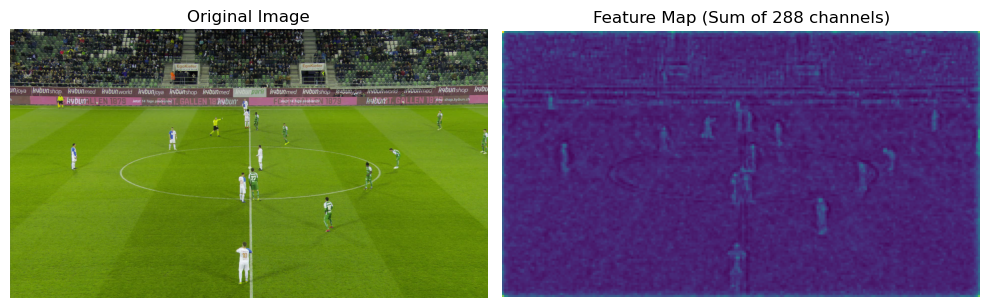

In [6]:
visualize_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1')

# Test Feature Extractor up to layer 6e

Output shape: torch.Size([1, 768, 65, 118])
Number of channels: 768
Spatial dimensions: 65x118
Image: 000001.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


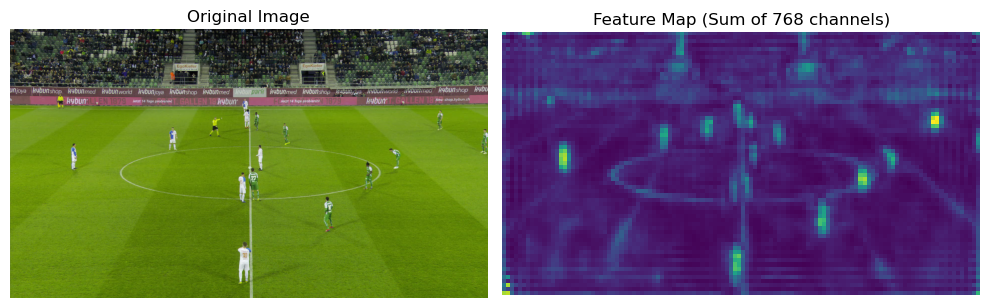

Image: 000002.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


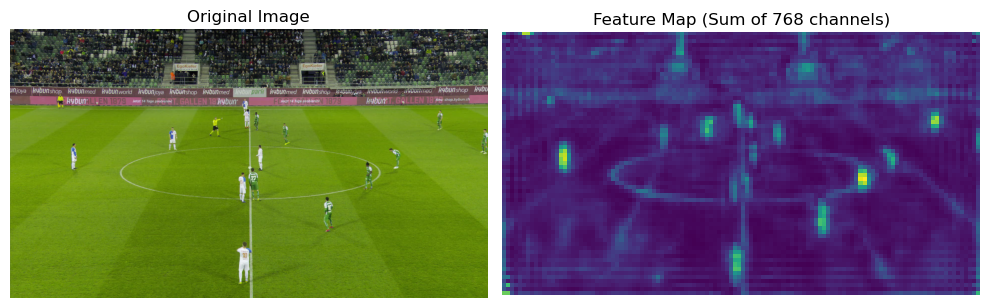

Image: 000003.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


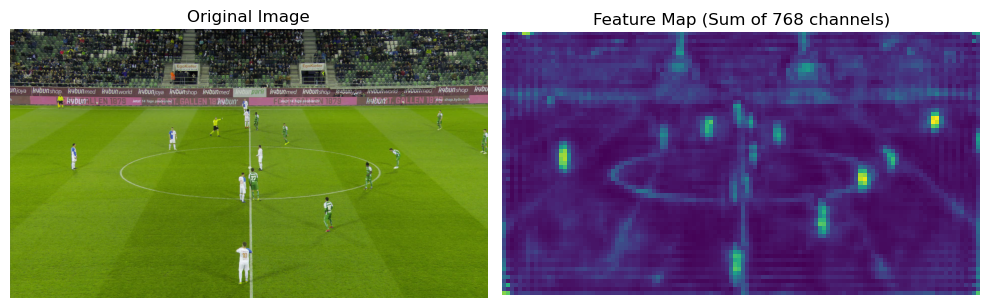

In [14]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            # model.Mixed_7a, 
            # model.Mixed_7b, 
            # model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
visualize_features(feature_extractor)

# Test Feature Extractor up to layer 7c

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58
Image: 000001.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 2048, 32, 58])


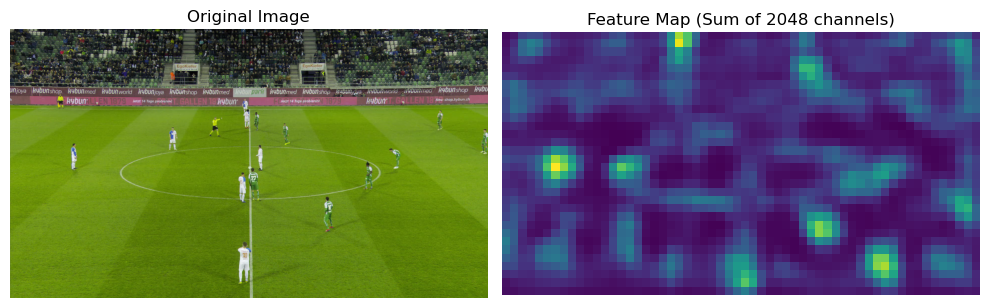

Image: 000002.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 2048, 32, 58])


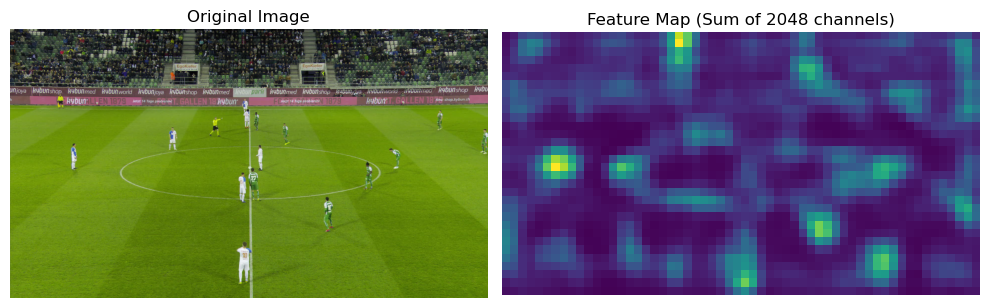

Image: 000003.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 2048, 32, 58])


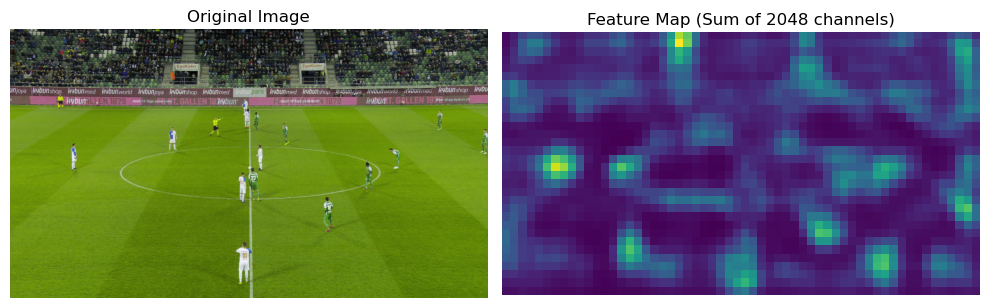

In [8]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
visualize_features(feature_extractor)

# The layer 7c features seem a little too low resolution. 
## After trying more of the layer 6X, layer 6d or 6e seems to strike the best balance between resolution and semantic information. 

Output shape: torch.Size([1, 768, 65, 118])
Number of channels: 768
Spatial dimensions: 65x118
Image: 000001.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


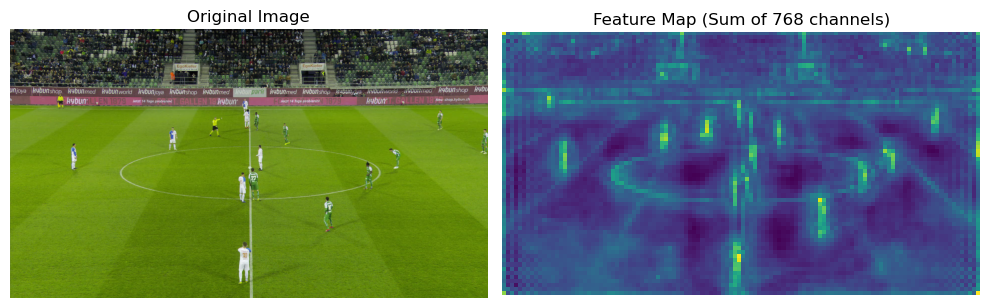

Image: 000002.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


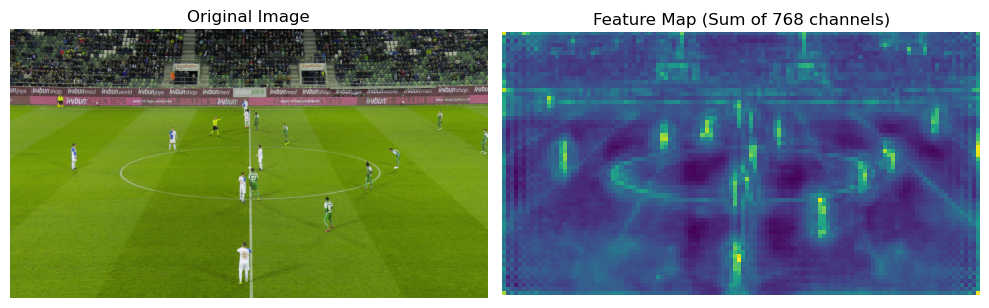

Image: 000003.jpg
Original image dimensions: 1920x1080
Feature map shape: torch.Size([1, 768, 65, 118])


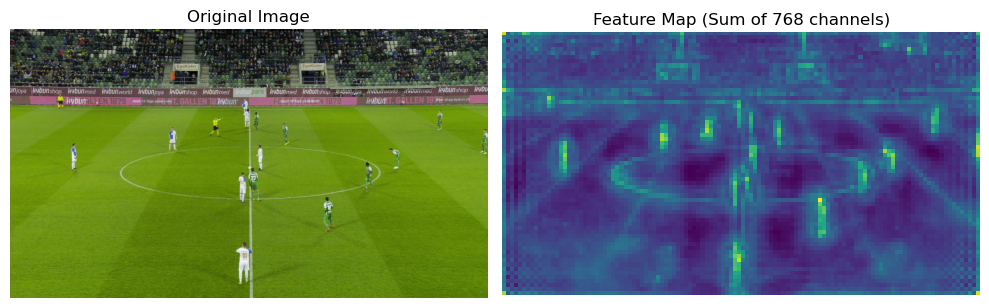

In [27]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            # model.Mixed_6e,
            # model.Mixed_7a, 
            # model.Mixed_7b, 
            # model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
visualize_features(feature_extractor)